In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 

import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")
sys.path.insert(0, "./src")
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate,random_cost,cut_off_cost
from unet import UNet
# from predict import predict_img
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# go in all of the subfolders and get the names of the files with the folder appended
fnames = []
for root, dirs, files in os.walk(config['PATHS']['progress_results']):
    for file in files:
        if file.endswith("results.pkl"):
             fnames.append(os.path.join(root, file))

In [53]:
# fnames = sorted([oj(config['PATHS']['progress_results'] , fname) for fname in os.listdir(config['PATHS']['progress_results'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
results[['foldername', 'best_val_score', 'cost_function', 'add_ratio','experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).mean()

,,,,best_val_score
experiment_name,cost_function,foldername,add_ratio,
ActiveLearning,cut_off_cost,DataLNOop,0.02,0.68


In [54]:
results.columns

Index(['file_name', 'epochs', 'batch_size', 'cost_function', 'add_ratio',
       'foldername', 'poolname', 'experiment_name', 'lr', 'image_size',
       'add_size', 'offset', 'seed', 'val', 'export_results', 'add_step',
       'progress_folder', 'final_patience', 'num_batches', 'class_dict',
       'data_min', 'data_max', 'val_scores', 'train_losses', 'num_classes',
       'best_val_score'],
      dtype='object')

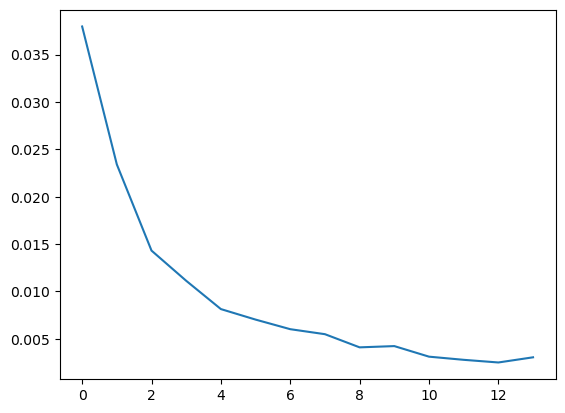

In [55]:
plt.plot(results.train_losses[0])

In [56]:
results.val_scores[0]

[0.2551649510860443,
 0.3092937469482422,
 0.3205334544181824,
 0.3653387427330017,
 0.5062761306762695,
 0.6402028799057007,
 0.6486219167709351,
 0.6813408732414246,
 0.653626561164856,
 0.6651504039764404,
 0.6634608507156372,
 0.6632819175720215,
 0.6649631261825562,
 0.6710774898529053]

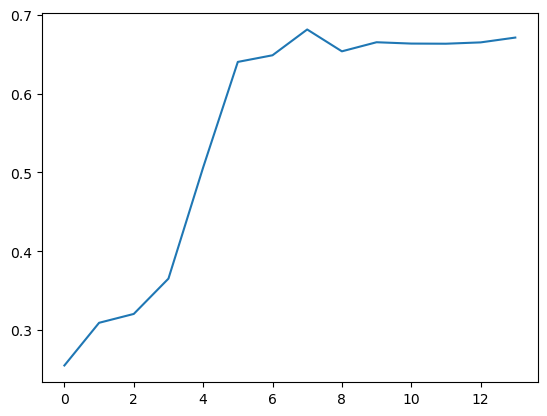

In [57]:
plt.plot(results.val_scores[0])

In [58]:
my_id = 0

In [59]:
net = UNet(1, 3, ).to(device)
# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['progress_results'], '2054813171', 'model_state.pt')))
net = net.to(device).eval()

In [60]:
net = net.train()

In [61]:
x,y,num_classes,class_dict = my_data.load_layer_data(oj(data_path, 'DataLNOop'))
# x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))
x, y = x[:-4], y[:-4]  # just don't touch the last four
data_max, data_min = x.max(), x.min()
x = (x - data_min) / (data_max - data_min)
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [62]:
x,y,num_classes,class_dict = my_data.load_layer_data(oj(data_path, 'DataLNOop'))
# x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))
x, y = x[:-4], y[:-4]  # just don't touch the last four
data_max, data_min = x.max(), x.min()
x = (x - data_min) / (data_max - data_min)
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [63]:
x_pool = my_data.load_pool_data( oj(data_path, 'voltif_LNOop') )

In [64]:
class_dict

{0: 64, 1: 153, 2: 242}

In [65]:
img_idx = 0
test_img_np  = ((x_pool[100][None,:].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

In [ ]:
output.sum(axis=0)

(512, 512)

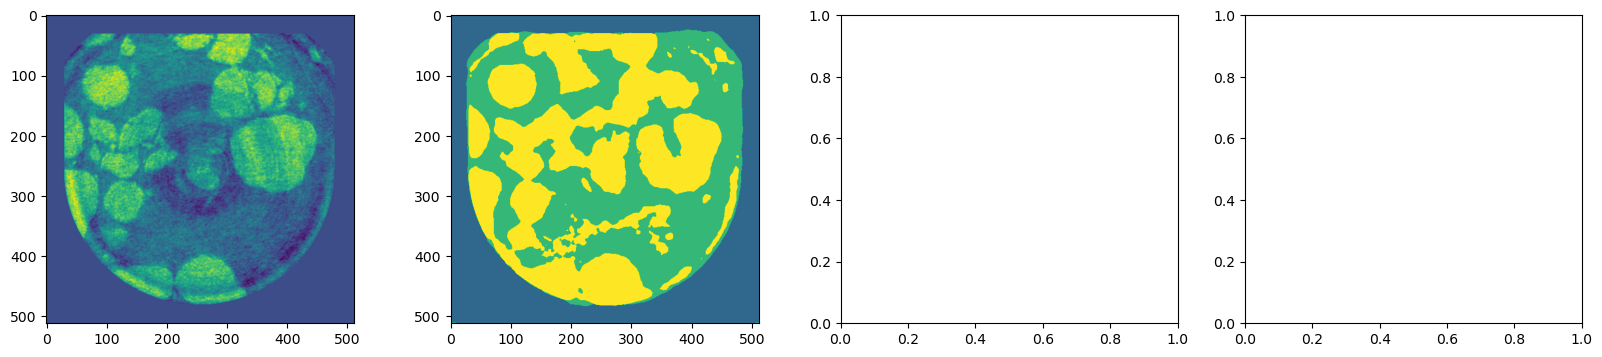

In [48]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,4))
axes[0].imshow(test_img_np[0,0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
# target = np.copy(y[all_train_idxs[img_idx]]).astype(np.int16)
# target[np.where(target == 255)] =-1
# axes[2].imshow(target, vmin =-1,vmax = 2)
# axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))
# axes[1].imshow()

# old, not pool

In [25]:
img_idx = 0
test_img_np  = ((x[all_train_idxs[img_idx]][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

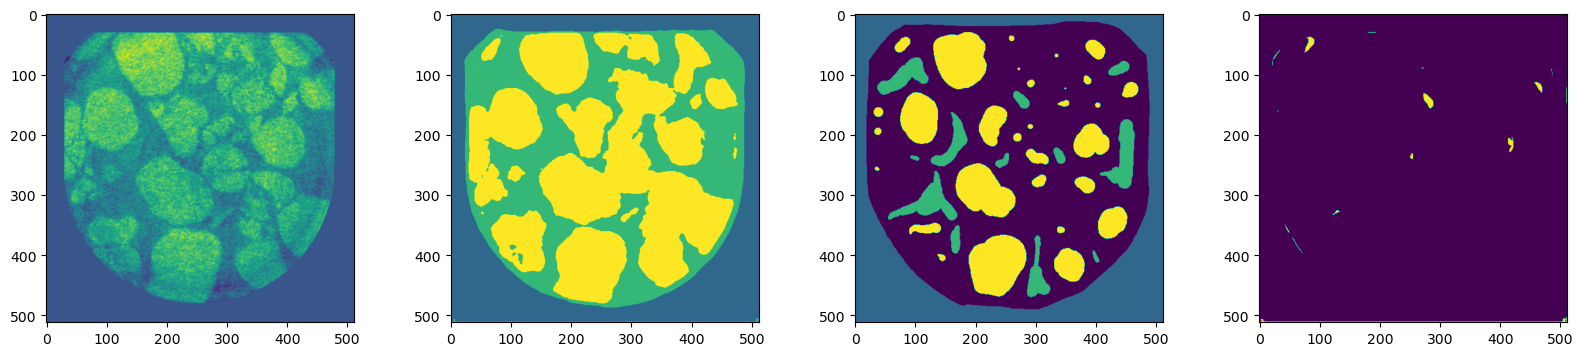

In [27]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
axes[0].imshow(x[all_train_idxs[img_idx]][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[all_train_idxs[img_idx]]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))
# axes[1].imshow()

In [93]:
(train_add_set, new_val_set) = my_data.load_annotated_imgs( oj( config["PATHS"]["progress_results"], 
                                                               results.file_name[0], ), 
                                                               class_dict, )
loader_args = dict( batch_size=1, num_workers=0, pin_memory=True )
val_loader = DataLoader(train_add_set, shuffle=False, drop_last=False, **loader_args)

[ 26  89 242]


In [94]:
output_list = give_results( net, device, val_loader,)

In [95]:
my_idx = 0


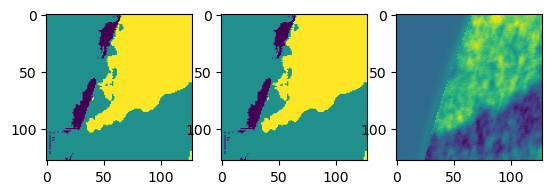

In [99]:
# my_idx = 1
fig, axes = plt.subplots(ncols=3)
axes[0].imshow(train_add_set[my_idx][1])
axes[1].imshow(output_list[my_idx])

axes[2].imshow(train_add_set[my_idx][0][0])
my_idx+=1


In [103]:
np.power(.5, 64)

5.421010862427522e-20

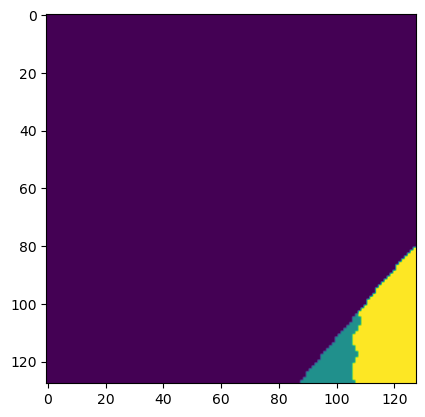

In [47]:
plt.imshow(train_add_set[0][1])

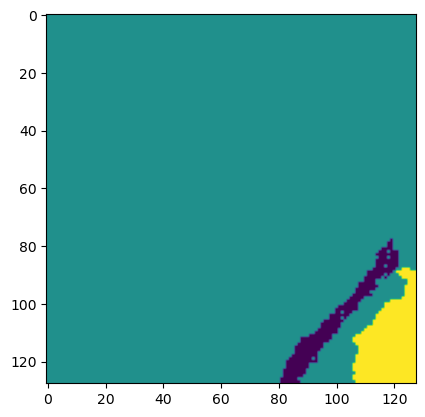

In [46]:
plt.imshow(output_list[0])

In [41]:
results.foldername[my_id]


0    DataLNO
Name: foldername, dtype: object

In [42]:
x, y, num_classes, class_dict = my_data.load_layer_data( oj(config["DATASET"]["data_path"], results.foldername[my_id]))

In [43]:
annotated_set = my_data.load_annotated_imgs(oj(config["PATHS"]["progress_results"], dirs[my_id], ), class_dict)

[ 26.  89. 242.]


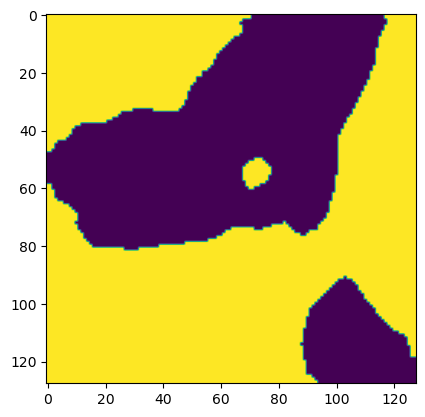

In [50]:
plt.imshow(annotated_set[3][1].numpy())

In [ ]:
load_annotated_imgs

In [51]:
dirs = [oj(config['PATHS']['progress_results'], x) for x in os.listdir(config['PATHS']['progress_results']) if os.path.isdir(oj(config['PATHS']['progress_results'], x))]

data_folder = oj(dirs[my_id], 'predictions')


In [52]:
# load the exported images and try this
# find the folder 
filenames = [x for x in os.listdir(data_folder) ]
img_list = []
for file_name in files:  # careful: currently depends on order of files

    im = io.imread(oj(data_folder, file_name))
    img_list.append(im)


In [56]:
img_list[0].shape

(128, 128)

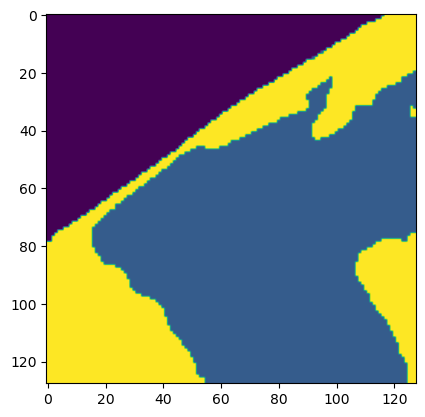

In [53]:
plt.imshow(img_list[0])

In [40]:
img_list[0].shape

(128, 128)

# try with detailed

In [ ]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [ ]:
val_loader.batch_size

In [ ]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [ ]:
x_small[test_idxes].min()

In [ ]:
net(t)

In [ ]:
x.shape

In [ ]:
val_loader

In [ ]:
net

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)

In [ ]:
len(val_loader.dataset)

In [ ]:
test_ids_safe

In [ ]:
plt.imshow(val_set[test_ids_safe[0]][0][0])

In [ ]:
plt.imshow(val_set[test_ids_safe[-20]][0][0])

In [ ]:
test_ids_safe[32]

In [ ]:
test_ids_safe[23]

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
net(val_set[test_ids_safe[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][0].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][2].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1)

In [ ]:
test_ids_safe[224]

In [ ]:
len(test_ids_safe)

In [ ]:
test_ids = np.sort(test_ids)

In [ ]:
plt.imshow(val_set[5][0][0])

In [ ]:
plt.imshow(val_set[test_ids[10]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[1]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[0]][0][0])

In [ ]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [ ]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

In [ ]:
len(val_loader)

In [ ]:
val_loader

In [ ]:
eva

In [ ]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [ ]:
np.where((my_std < np.quantile(my_std, .1)))

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
output.shape

In [ ]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

In [ ]:
from dice_score import dice_loss

In [ ]:
dice_loss()

In [ ]:
num_classes

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]